In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px 
import seaborn as sns

plt.style.use('seaborn')

from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import norm

from scipy.stats import ttest_ind

C:\Users\Admin\AppData\Local\Temp\ipykernel_10136\3512115176.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
df = pd.read_excel('data/Data Analyst - Test Tasks.xlsx', sheet_name=1)
df.head()

,Id,Ad headline,Ad Call to action,Date,Conversions,Clicks,Cost,Impressions
0,1,Three best options for business expansion,Lean More,2021-09-01,19.114284,859,5062.970530,35295
1,2,Three best options for business expansion,Lean More,2021-10-01,22.000000,1707,10510.584357,64999
2,3,Three best options for business expansion,Lean More,2021-11-01,27.600000,1316,9045.799412,61909
3,4,Three best options for business expansion,Lean More,2021-12-01,18.000000,1060,6777.109898,73164
4,5,Three best options for business expansion,Lean More,2022-01-01,14.900000,855,7425.284524,59653


In [3]:
df['Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d')

In [4]:
df['conversion'] = (df['Conversions'] / df['Impressions']) * 100

Let's look at the average and median of the target metric by advertising company

In [5]:
df.groupby('Ad Call to action')['conversion'].agg(['mean', 'median'])

,mean,median
Ad Call to action,,
Book Now,0.119557,0.086258
Lean More,0.044174,0.046120


The resulting table shows that the median and mean in each group differ. Moreover, the difference between the indicators in the groups is more than 50%! Let us make sure that the difference in indicators is significant and is not due to chance.

Before doing this, we'll use cumulative metrics to make sure that the conversion rate is stable over time.

In [6]:
df['cum_converted'] = df.groupby('Ad Call to action')['Conversions'].cumsum()
df['cum_users_count'] = df.groupby('Ad Call to action')['Impressions'].cumsum()
df['cum_conversion'] = df['cum_converted'] / df['cum_users_count'] * 100

df.head()

,Id,Ad headline,Ad Call to action,Date,Conversions,Clicks,Cost,Impressions,conversion,cum_converted,cum_users_count,cum_conversion
0,1,Three best options for business expansion,Lean More,2021-09-01,19.114284,859,5062.970530,35295,0.054156,19.114284,35295,0.054156
1,2,Three best options for business expansion,Lean More,2021-10-01,22.000000,1707,10510.584357,64999,0.033847,41.114284,100294,0.040994
2,3,Three best options for business expansion,Lean More,2021-11-01,27.600000,1316,9045.799412,61909,0.044582,68.714284,162203,0.042363
3,4,Three best options for business expansion,Lean More,2021-12-01,18.000000,1060,6777.109898,73164,0.024602,86.714284,235367,0.036842
4,5,Three best options for business expansion,Lean More,2022-01-01,14.900000,855,7425.284524,59653,0.024978,101.614284,295020,0.034443


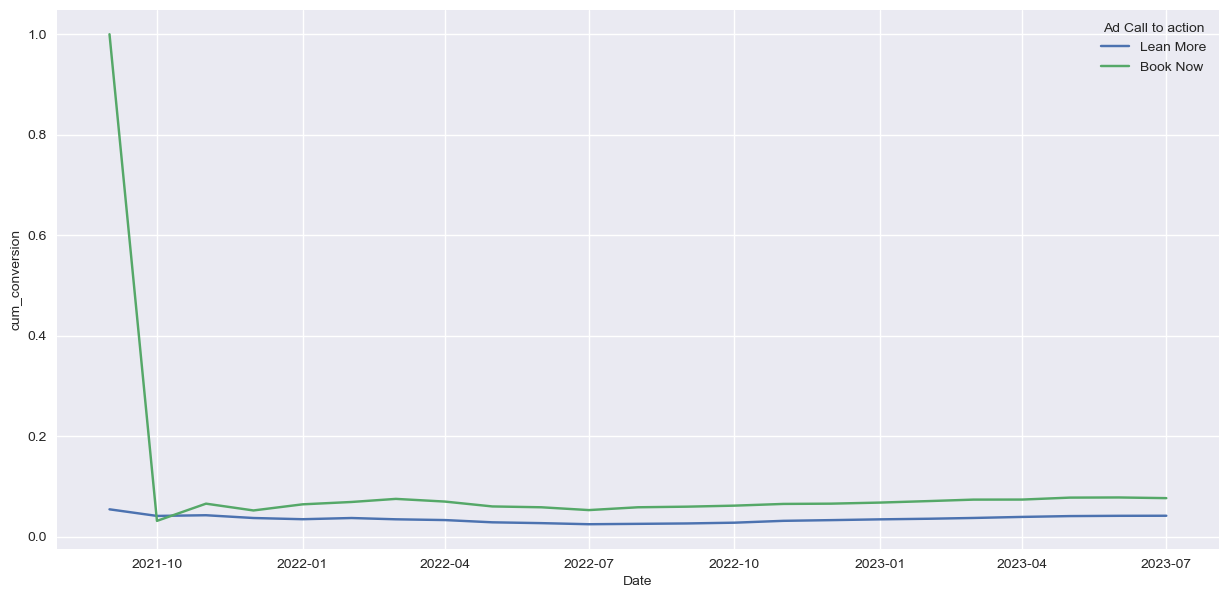

In [7]:
fig = plt.figure(figsize=(15,7))

sns.lineplot(
    data = df,
    x = 'Date',
    y = 'cum_conversion',
    hue = 'Ad Call to action'
);

We see that the conversion has stabilized, there are no jumps. Also on the graph we can see that the conversion of the Lean More group is consistently worse than the conversion of the Book Now group.

The data is stable, which means you can start implementing statistical tests.

In [8]:
ab_data = df.groupby('Ad Call to action')[['Impressions', 'Conversions']].sum()

ab_data

,Impressions,Conversions
Ad Call to action,,
Book Now,1217150,930.000000
Lean More,1244758,514.714284


As a null hypothesis, we denote that the Book Now conversion is a Lean More conversion <= 0. As an alternative hypothesis, we denote that the Book Now conversion is a Lean More conversion > 0

In [9]:
alpha = 0.05

_, p_value = proportions_ztest(
    count = ab_data['Conversions'],
    nobs = ab_data['Impressions'],
    alternative = 'larger'
)

print(f'p-value = {p_value}')

if p_value <= alpha:
    print('Rejecting the null hypothesis')
else:
    print('We cannot reject the null hypothesis')
    

p-value = 3.4559840031141364e-30
Rejecting the null hypothesis


Based on the test results, we reject the null hypothesis and accept the alternative, that the Book Now conversion is higher than the Lean More conversion

Let's try to build a confidence interval

In [10]:
def diff_proportion_conf_interval(x_p, n, gamma=0.95):
    alpha = 1 - gamma 
    diff = x_p[1] - x_p[0] 
    z_crit = -norm.ppf(alpha/2)
    eps = z_crit * (x_p[0] * (1 - x_p[0])/n[0] + x_p[1] * (1 - x_p[1])/n[1]) ** 0.5
    lower_bound = diff - eps 
    upper_bound = diff + eps
    
    return lower_bound, upper_bound

In [19]:
n = [ab_data.loc['Book Now', 'Impressions'], ab_data.loc['Lean More', 'Impressions']]
x_p = [ab_data.loc['Book Now', 'Conversions'] / n[0], ab_data.loc['Lean More', 'Conversions'] / n[1]]

lower_bound, upper_bound = diff_proportion_conf_interval(x_p=x_p, n=n)

print('Confidence interval for conversion difference: {}'.format((round(lower_bound*100, 2), round(upper_bound*100, 2))))

Confidence interval for conversion difference: (-0.04, -0.03)


The true difference in conversion is negative. Book Now is better than Lean More in terms of conversion metrics with a reliability of 0.95.

Let's analyze the performance of two companies based on the ratio of the number of conversions to the number of clicks

In [11]:
ab_data = df.groupby('Ad Call to action')[['Clicks', 'Conversions']].sum()

ab_data

,Clicks,Conversions
Ad Call to action,,
Book Now,15836,930.000000
Lean More,16344,514.714284


In [12]:
alpha = 0.05

_, p_value = proportions_ztest(
    count = ab_data['Conversions'],
    nobs = ab_data['Clicks'],
    alternative = 'larger'
)

print(f'p-value = {p_value}')

if p_value <= alpha:
    print('Rejecting the null hypothesis')
else:
    print('We cannot reject the null hypothesis')

p-value = 2.0675495089035176e-32
Rejecting the null hypothesis


In [22]:
n = [ab_data.loc['Book Now', 'Clicks'], ab_data.loc['Lean More', 'Clicks']]
x_p = [ab_data.loc['Book Now', 'Conversions'] / n[0], ab_data.loc['Lean More', 'Conversions'] / n[1]]

lower_bound, upper_bound = diff_proportion_conf_interval(x_p=x_p, n=n)

print('Confidence interval for conversion difference: {}'.format((round(lower_bound*100, 2), round(upper_bound*100, 2))))

Confidence interval for conversion difference: (-3.06, -2.16)


According to this indicator, the company with the Book Now call shows even better results

Let’s test the proportion of clicks to ad impressions

In [13]:
ab_data = df.groupby('Ad Call to action')[['Impressions', 'Clicks']].sum()

ab_data

,Impressions,Clicks
Ad Call to action,,
Book Now,1217150,15836
Lean More,1244758,16344


In [14]:
alpha = 0.05

_, p_value = proportions_ztest(
    count = ab_data['Clicks'],
    nobs = ab_data['Impressions']
)

print(f'p-value = {p_value}')

if p_value <= alpha:
    print('Rejecting the null hypothesis')
else:
    print('We cannot reject the null hypothesis')

p-value = 0.4090020416676966
We cannot reject the null hypothesis


In [15]:
n = [ab_data.loc['Book Now', 'Impressions'], ab_data.loc['Lean More', 'Impressions']]
x_p = [ab_data.loc['Book Now', 'Clicks'] / n[0], ab_data.loc['Lean More', 'Clicks'] / n[1]]

lower_bound, upper_bound = diff_proportion_conf_interval(x_p=x_p, n=n)

print('Confidence interval for conversion difference: {}'.format((round(lower_bound*100, 2), round(upper_bound*100, 2))))

Confidence interval for conversion difference: (-0.02, 0.04)


According to this metric, there is no statistical difference between the results of advertising companies.

Finally, let’s compare the results of advertising companies in terms of cost per click and cost of conversion. First, let's compare the cost per click.

In [16]:
df['click_cost'] = df['Cost'] / df['Clicks']
df['conversion_cost'] = df['Cost'] / df['Conversions']

In [17]:
alpha = 0.05 

results = ttest_ind(
    a=df.loc[df['Ad Call to action'] == 'Book Now', 'click_cost'],
    b=df.loc[df['Ad Call to action'] == 'Lean More', 'click_cost'],
    alternative='two-sided'
)
print('p-value:', round(results.pvalue, 2))

if results.pvalue <= alpha:
    print("Rejecting the null hypothesis")
else:
    print("We have no reason to reject the null hypothesis")


p-value: 0.4
We have no reason to reject the null hypothesis


In [28]:
alpha = 0.05

results = ttest_ind(
    a=df.loc[df['Ad Call to action'] == 'Book Now', 'conversion_cost'],
    b=df.loc[df['Ad Call to action'] == 'Lean More', 'conversion_cost'],
    alternative='two-sided'
)
print('p-value:', round(results.pvalue, 2))


if results.pvalue <= alpha:
    print("Rejecting the null hypothesis")
else:
    print("We have no reason to reject the null hypothesis")

p-value: 0.75
We have no reason to reject the null hypothesis


Thus, in terms of cost per click and cost of conversion metrics, there is no statistical difference between the indicators of the two companies.